In [1]:
# =========================================
# 0) Warning Management (UYARI TEMİZLEME)
# =========================================
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =========================================
# 1) Kütüphaneler
# =========================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
from sklearn.decomposition import TruncatedSVD

# =========================================
# 2) Veri Yükleme
# =========================================
file_path = "/Users/revahauctepe/Desktop/Odunc_Guncel_Kategorili_Liste.xlsx"
df = pd.read_excel(file_path)

print("Data shape:", df.shape)
display(df.head())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDuplicated rows:", df.duplicated().sum())

print("\nTarget distribution (LC_Kategori):")
print(df["LC_Kategori"].value_counts())

# =========================================
# 3) Features ve Target
# =========================================
target_col = "LC_Kategori"

if "ÖğrenciKimlik-no" in df.columns:
    df_model = df.drop(columns=["ÖğrenciKimlik-no"])
else:
    df_model = df.copy()

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# =========================================
# 4) Train / Test Split
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================================
# 5) Preprocessing (OneHot + Scaling)
# =========================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(with_mean=False), numeric_features),
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

print("\nEncoded X_train shape:", X_train_enc.shape)

# =========================================
# 6) Model Değerlendirme Fonksiyonu
# =========================================
def eval_model(stage, name, model, X_tr, y_tr, X_te, y_te, results_list):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)

    print(f"\n=== {stage} | {name} ===")
    print("Accuracy:", acc)
    print("F1 macro:", f1)
    print("\nClassification Report:\n")
    print(classification_report(y_te, y_pred, zero_division=0))

    results_list.append({
        "Stage": stage,
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1
    })

# =========================================
# 7) Modeller (REVİZE)
# =========================================
logreg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

knn = KNeighborsClassifier(n_neighbors=7)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

results = []

# =========================================
# 8) Stage 1: Original Features
# (KNN çıkarıldı – yüksek boyut sebebiyle)
# =========================================
stage1 = "Original Features"

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage1, model_name, model,
        X_train_enc, y_train,
        X_test_enc, y_test,
        results
    )

# =========================================
# 9) Stage 2: Feature Selection (RFE)
# =========================================
stage2 = "After Feature Selection (RFE, 40 features)"

rfe_selector = RFE(
    estimator=LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        multi_class="multinomial"
    ),
    n_features_to_select=40,
    step=0.1
)

X_train_fs = rfe_selector.fit_transform(X_train_enc, y_train)
X_test_fs = rfe_selector.transform(X_test_enc)

print("\nAfter RFE shapes:", X_train_fs.shape, X_test_fs.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage2, model_name, model,
        X_train_fs, y_train,
        X_test_fs, y_test,
        results
    )

# =========================================
# 10) Stage 3: Dimension Reduction (TruncatedSVD)
# =========================================
stage3 = "After Dimension Reduction (TruncatedSVD, n=20)"

svd = TruncatedSVD(n_components=20, random_state=42)

X_train_dr = svd.fit_transform(X_train_enc)
X_test_dr = svd.transform(X_test_enc)

print("\nAfter DR shapes:", X_train_dr.shape, X_test_dr.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("KNN (k=7)", knn),
    ("RandomForest", rf)
]:
    eval_model(
        stage3, model_name, model,
        X_train_dr, y_train,
        X_test_dr, y_test,
        results
    )

# =========================================
# 11) Summary Table (AKADEMİK)
# =========================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=["F1_macro", "Accuracy"],
    ascending=False
).reset_index(drop=True)

print("\n===== Summary Table (Accuracy & F1) =====")
display(results_df)


Data shape: (13436, 6)


,ÖğrenciKimlik-no,Cinsiyet,Fakülte,Bölüm,Kitap-ID,LC_Kategori
0,509005326,Kadın,Turizm Fakültesi,Gastronomi ve Mutfak Sanatları,GY151,Genel Yapıtlar
1,421475486,Kadın,Mühendislik ve Doğa Bilimleri Fakültesi,Biyomühendislik,B3004,Bilim
2,660301107,Erkek,Sağlık Bilimleri Fakültesi,Odyoloji,Tip4081,Tıp
3,534575034,Kadın,Edebiyat Fakültesi,Sosyoloji Bölümü,DE2527,Dil ve Edebiyat
4,331718324,Kadın,Hukuk Fakültesi,Hukuk Bölümü,H9821,Hukuk



Missing values per column:
ÖğrenciKimlik-no    0
Cinsiyet            0
Fakülte             0
Bölüm               0
Kitap-ID            0
LC_Kategori         0
dtype: int64

Duplicated rows: 0

Target distribution (LC_Kategori):
LC_Kategori
Dil ve Edebiyat             3274
Tıp                         2703
Hukuk                       1016
Siyaset Bilimi              1001
Felsefe, Psikoloji, Din      965
Bilim                        957
Güzel Sanatlar               952
Eğitim                       913
Sosyal Bilimler              904
Müzik                         79
Askerlik                      74
Kaynakçalar                   72
Tarih                         71
Genel Yapıtlar                69
Denizcilik                    69
Tarihe Yardımcı Bilimler      67
Bilinmeyen                    66
Coğrafya                      64
Tarım                         63
Teknoloji                     57
Name: count, dtype: int64

Numeric features: []
Categorical features: ['Cinsiyet', 'Fakülte', 'Bölü

,Stage,Model,Accuracy,F1_macro
0,Original Features,RandomForest,0.732143,0.366005
1,"After Feature Selection (RFE, 40 features)",RandomForest,0.731771,0.365822
2,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.681920,0.345891
3,Original Features,LogisticRegression,0.730655,0.345195
4,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.730655,0.345195
5,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.730655,0.345195
6,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.718750,0.341714


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)


In [3]:
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader

# ================================
# Label Encoding (PyTorch için)
# ================================
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

# ================================
# Torch tensor formatına çevir
# ================================
X_train_torch = torch.tensor(X_train_enc.toarray(), dtype=torch.float32)
X_test_torch  = torch.tensor(X_test_enc.toarray(), dtype=torch.float32)

y_train_torch = torch.tensor(y_train_enc, dtype=torch.long)
y_test_torch  = torch.tensor(y_test_enc, dtype=torch.long)

# ================================
# Dataset & DataLoader
# ================================
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ================================
# Model parametreleri
# ================================
input_dim = X_train_torch.shape[1]
num_classes = len(label_encoder.classes_)

print("Input dim:", input_dim)
print("Num classes:", num_classes)


Input dim: 9789
Num classes: 20


In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).numpy())
            y_prob.extend(probs.numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr")

    return acc, prec, rec, f1, auc


In [ ]:
mlp_model = MLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

train_model(mlp_model, train_loader, criterion, optimizer, epochs=20)

mlp_results = evaluate_model(mlp_model, test_loader)
print("MLP Results (Acc, Prec, Recall, F1, AUC):", mlp_results)


Epoch 1/20 - Loss: 259.4794


In [ ]:
deep_mlp_model = DeepMLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp_model.parameters(), lr=0.001)

train_model(deep_mlp_model, train_loader, criterion, optimizer, epochs=25)

deep_mlp_results = evaluate_model(deep_mlp_model, test_loader)
print("Deep MLP Results (Acc, Prec, Recall, F1, AUC):", deep_mlp_results)


Epoch 1/25 - Loss: 187.8011
Epoch 2/25 - Loss: 123.6900
Epoch 3/25 - Loss: 57.8960
Epoch 4/25 - Loss: 31.6567
Epoch 5/25 - Loss: 14.8474
Epoch 6/25 - Loss: 5.5838
Epoch 7/25 - Loss: 3.2917
Epoch 8/25 - Loss: 2.0166
Epoch 9/25 - Loss: 1.7774
Epoch 10/25 - Loss: 1.4022
Epoch 11/25 - Loss: 2.0851
Epoch 12/25 - Loss: 4.5523
Epoch 13/25 - Loss: 5.3987
Epoch 14/25 - Loss: 5.1680
Epoch 15/25 - Loss: 5.6023
Epoch 16/25 - Loss: 5.4007
Epoch 17/25 - Loss: 3.7652
Epoch 18/25 - Loss: 3.3624
Epoch 19/25 - Loss: 2.5755
Epoch 20/25 - Loss: 2.7494
Epoch 21/25 - Loss: 2.1642
Epoch 22/25 - Loss: 1.8205
Epoch 23/25 - Loss: 1.9981
Epoch 24/25 - Loss: 1.2454
Epoch 25/25 - Loss: 1.3570
Deep MLP Results (Acc, Prec, Recall, F1, AUC): (0.7440476190476191, 0.6341754717870798, 0.4786425316711383, 0.4646736175445848, 0.7921434622933592)


In [ ]:
results.append({
    "Stage": "Final - PyTorch",
    "Model": "MLP",
    "Accuracy": mlp_results[0],
    "F1_macro": mlp_results[3]
})

results.append({
    "Stage": "Final - PyTorch",
    "Model": "Deep MLP",
    "Accuracy": deep_mlp_results[0],
    "F1_macro": deep_mlp_results[3]
})

results_df = pd.DataFrame(results)
display(results_df)


,Stage,Model,Accuracy,F1_macro
0,Original Features,LogisticRegression,0.730655,0.345195
1,Original Features,RandomForest,0.732143,0.366005
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.730655,0.345195
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.731771,0.365822
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.730655,0.345195
5,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.718750,0.341714
6,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.681920,0.345891
7,Final - PyTorch,MLP,0.756696,0.516593
8,Final - PyTorch,Deep MLP,0.744048,0.464674


In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [ ]:
def plot_multiclass_roc(model, test_loader, n_classes, title):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_score.extend(probs.numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-vs-Rest için binarize
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


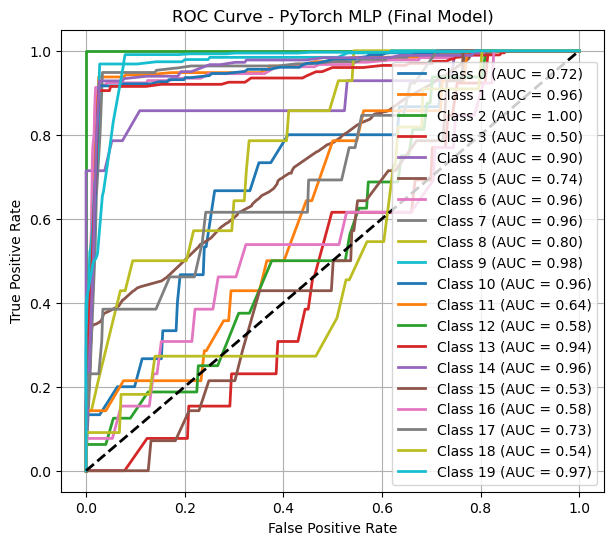

In [ ]:
plot_multiclass_roc(
    model=mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch MLP (Final Model)"
)


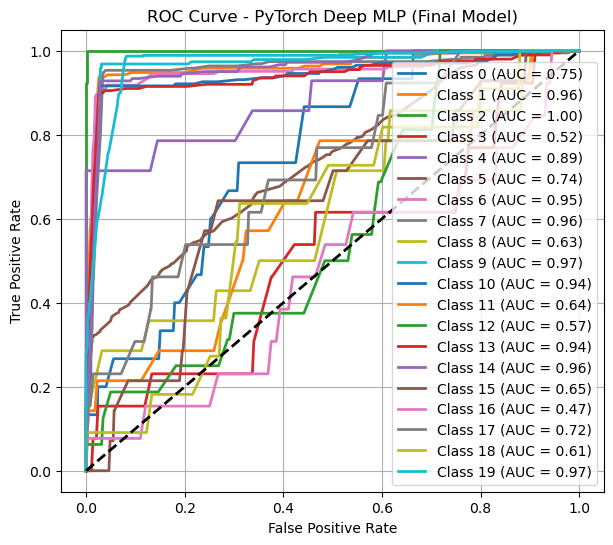

In [ ]:
plot_multiclass_roc(
    model=deep_mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch Deep MLP (Final Model)"
)


In [ ]:
tuning_results = []

learning_rates = [0.01, 0.001]
epochs_list = [15, 25]

for lr in learning_rates:
    for ep in epochs_list:
        model = MLP(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_model(model, train_loader, criterion, optimizer, epochs=ep)
        acc, prec, rec, f1, auc_score = evaluate_model(model, test_loader)

        tuning_results.append({
            "Model": "MLP",
            "LearningRate": lr,
            "Epochs": ep,
            "Accuracy": acc,
            "F1": f1,
            "AUC": auc_score
        })


Epoch 1/15 - Loss: 187.3254
Epoch 2/15 - Loss: 109.8551
Epoch 3/15 - Loss: 37.8990
Epoch 4/15 - Loss: 10.8382
Epoch 5/15 - Loss: 2.0715
Epoch 6/15 - Loss: 0.5358
Epoch 7/15 - Loss: 0.2699
Epoch 8/15 - Loss: 0.1539
Epoch 9/15 - Loss: 0.0930
Epoch 10/15 - Loss: 0.0773
Epoch 11/15 - Loss: 0.0513
Epoch 12/15 - Loss: 0.0423
Epoch 13/15 - Loss: 0.0319
Epoch 14/15 - Loss: 0.0293
Epoch 15/15 - Loss: 0.0197
Epoch 1/25 - Loss: 187.2936
Epoch 2/25 - Loss: 109.0606
Epoch 3/25 - Loss: 37.6846
Epoch 4/25 - Loss: 10.6503
Epoch 5/25 - Loss: 1.8649
Epoch 6/25 - Loss: 0.5238
Epoch 7/25 - Loss: 0.2299
Epoch 8/25 - Loss: 0.1257
Epoch 9/25 - Loss: 0.0904
Epoch 10/25 - Loss: 0.0609
Epoch 11/25 - Loss: 0.0604
Epoch 12/25 - Loss: 0.0421
Epoch 13/25 - Loss: 0.0377
Epoch 14/25 - Loss: 0.0276
Epoch 15/25 - Loss: 0.0191
Epoch 16/25 - Loss: 0.0207
Epoch 17/25 - Loss: 0.0170
Epoch 18/25 - Loss: 0.0136
Epoch 19/25 - Loss: 0.0158
Epoch 20/25 - Loss: 0.0107
Epoch 21/25 - Loss: 0.0079
Epoch 22/25 - Loss: 0.0084
Epoch 2

In [ ]:
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)


,Model,LearningRate,Epochs,Accuracy,F1,AUC
0,MLP,0.010,15,0.739955,0.512006,0.793437
1,MLP,0.010,25,0.751488,0.514795,0.796279
2,MLP,0.001,15,0.754092,0.503074,0.796187
3,MLP,0.001,25,0.757068,0.516836,0.799199


In [ ]:
final_results = results_df.copy()

final_results.loc[len(final_results)] = [
    "Final - PyTorch", "MLP (Best Tuned)",
    mlp_results[0], mlp_results[3]
]

final_results.loc[len(final_results)] = [
    "Final - PyTorch", "Deep MLP",
    deep_mlp_results[0], deep_mlp_results[3]
]

display(final_results)


,Stage,Model,Accuracy,F1_macro
0,Original Features,LogisticRegression,0.730655,0.345195
1,Original Features,RandomForest,0.732143,0.366005
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.730655,0.345195
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.731771,0.365822
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.730655,0.345195
5,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.718750,0.341714
6,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.681920,0.345891
7,Final - PyTorch,MLP,0.756696,0.516593
8,Final - PyTorch,Deep MLP,0.744048,0.464674
9,Final - PyTorch,MLP (Best Tuned),0.756696,0.516593


In [ ]:
best_model = final_results.sort_values("F1_macro", ascending=False).iloc[0]

print("Best Model Based on F1-score:")
print(best_model)


Best Model Based on F1-score:
Stage       Final - PyTorch
Model                   MLP
Accuracy           0.756696
F1_macro           0.516593
Name: 7, dtype: object
